### Objective :  
- We will learn to implement a sequence to sequence model which can tranlate German(encoder) to English(decoder) Language.

### Dataset Used
- The dataset we'll be using is the Multi30k dataset. This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

### Packed Padded Sequence:
- It is used when working with variable length data such as sentences of different length.
- They allow us to process sequences of different length in batches efficiently without wasting memory or computation on padded parts of sequences.

In [1]:
import spacy
import time
import random
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

E:\sequence\sequence\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Declare Random Seed for constant results

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Decalare German and English Tokenizers

In [3]:
german_tokenizer = spacy.load("de_core_news_sm")
english_tokenizer = spacy.load("en_core_web_sm")

In [4]:
def tokenize_german(text):
    return [token.text for token in german_tokenizer.tokenizer(text)]
def tokenize_english(text):
    return [token.text for token in english_tokenizer.tokenizer(text)]

#### AS we are using packed_padded_sequence, hence we need to tell Pytorch what is length of actual sentence. Which we can do using arg `include_lengths` of Field 

In [5]:
SRC = Field(tokenize=tokenize_german,init_token='<sos>',eos_token='<sos>',lower=True,include_lengths=True)
TRG = Field(tokenize=tokenize_english, init_token='<sos>',eos_token='<sos>',lower=True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Creating iterators

In [9]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc= nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #src =[src_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src_len, batch_size, emb_dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        packed_outputs, hidden = self.rnn(packed_embedded)
        # outputs = [src_len, batch_size, hid_dim* num_directions]
        # hidden = [n_layers*num_directions , batch_size, hid dim]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1 )))
        #outputs = [src_len, batch_size, enc_hid_dim*2]
        #hidden = [batch_size, dec_hid_dim]
        return outputs,hidden

#### nn.Linear Layer = Takes input feature vectors and applies a matrix multiplication operation with a weight matrix to produce a vector of output features. The weight matrix contains learning parameters that are adjusted during training process to optimize performance of nn. 
- y = Wx+b , The bias vector is added to output of matrix multiplication to shift activation function to left or right

#### F.softmax = Takes vector of real numbers as input and converts them to vector of probabilities. Where each element of output vector represents the probability of the corresponding input element belonging to a particular class

In [11]:
import torch

# define input tensor
x = torch.randn(4, 5)

# compute softmax over the second dimension
softmax_x = torch.nn.functional.softmax(x, dim=1)

# print results
print(x)
print(softmax_x)

tensor([[-0.1117, -0.4966,  0.1631, -0.8817,  0.2891],
        [ 0.4899, -0.3853, -0.7120,  0.6369, -0.7141],
        [-1.0831, -0.5547, -1.3248,  0.6970, -0.6631],
        [ 1.2158, -2.5273,  1.4778, -0.1696, -0.9919]])
tensor([[0.2019, 0.1374, 0.2658, 0.0935, 0.3015],
        [0.3149, 0.1312, 0.0947, 0.3648, 0.0945],
        [0.0915, 0.1551, 0.0718, 0.5424, 0.1392],
        [0.3727, 0.0088, 0.4843, 0.0932, 0.0410]])


In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attention = nn.Linear((enc_hid_dim*2)+dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
        
    def forward(self, hidden, enc_outputs, mask):
        #enc_outputs = [src_len, batch_size, enc_hid_dim*2]
        # hidden = [ batch_size, dec_hid_dim]
        batch_size = enc_outputs.shape[1]
        src_len = enc_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden= [batch_size,src_len, dec_hid_dim]
        enc_outputs = enc_outputs.permute(1,0,2)
        #enc_outputs = [batch_size, src_len, enc_hid_dim*2]
        energy = torch.tanh(self.attention(torch.cat((hidden,enc_outputs),dim=2)))
        # enrgy =  [batch_size,src_len, dec_hid_dim
        attention = self.v(energy).squeeze(2)
        #attn = [batch size, src len]
        attention = attention.masked_fill(mask==0, -1e10)
        return F.softmax(attention,dim=1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim*2)+emb_dim, dec_hid_dim)
        self.fc = nn.Linear((enc_hid_dim*2)+dec_hid_dim+emb_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp, hidden, enc_outputs,mask):
        #inp = [batch_size]
        #hidden = [batch_size,dec_hid_dim ]
        #enc_outputs = [src_len, batch_size,enc_hid_dim*2]
        inp = inp.unsqueeze(0)
        #inp = [1,batch_size]
        embedded = self.dropout(self.embedding(inp))
        #embedded =[1,batch_size,emb_dim]
        a = self.attention(hidden, enc_outputs,mask)
        #a = [batch_size, src_len]
        a = a.unsqueeze(1)
        #a = [batch_size,1, src_len]
        enc_outputs = enc_outputs.permute(1,0,2)
        #enc_outputs = [batch_size,src_len,enc_hid_dim*2]
        weighted= torch.bmm(a,enc_outputs)
        #weighted = [batch_size,1,enc_hid_dim*2]
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1,batch_size,enc_hid_dim*2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        #rnn_input = [1, batch_size,(enc_hid_dim*2)+emb_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [src_len,batch_size, dec_hid_dim*n_directions]
        #hidden = [n_layers* n_directions, batch_size, dec_hid_dim]
        # As src_len, n_layers &  n_directions = 1
        #output = [1,batch_size, dec_hid_dim]
        #hidden = [1,batch_size, dec_hid_dim]
        assert (output==hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        pred = self.fc(torch.cat((output,weighted,embedded), dim=1))
        #pred = [batch_size,output_dim]
        return pred, hidden.squeeze(0),a.squeeze(1)

In [14]:
class seq2seq(nn.Module):
    def __init__(self,encoder, decoder,src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
    
    def create_mask(self, src):
        mask = (src!= self.src_pad_idx).permute(1,0)
        return mask
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src = [src_len,batch_size ]
        #src_len = [batch_size]
        #trg = [trg_len,batch_size]
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
        inp = trg[0,:]
        mask = self.create_mask(src)

        #mask = [batch size, src len]
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(inp, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            inp = trg[t] if teacher_force else top1
            
        return outputs

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = seq2seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(7852, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5892, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5892, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 25s
	Train Loss: 5.076 | Train PPL: 160.089
	 Val. Loss: 4.885 |  Val. PPL: 132.319
Epoch: 02 | Time: 1m 58s
	Train Loss: 4.159 | Train PPL:  64.019
	 Val. Loss: 4.184 |  Val. PPL:  65.617
Epoch: 03 | Time: 1m 45s
	Train Loss: 3.407 | Train PPL:  30.165
	 Val. Loss: 3.675 |  Val. PPL:  39.445
Epoch: 04 | Time: 1m 37s
	Train Loss: 2.890 | Train PPL:  17.995
	 Val. Loss: 3.427 |  Val. PPL:  30.793
Epoch: 05 | Time: 1m 32s
	Train Loss: 2.514 | Train PPL:  12.360
	 Val. Loss: 3.297 |  Val. PPL:  27.034
Epoch: 06 | Time: 1m 31s
	Train Loss: 2.209 | Train PPL:   9.103
	 Val. Loss: 3.266 |  Val. PPL:  26.210
Epoch: 07 | Time: 1m 41s
	Train Loss: 1.979 | Train PPL:   7.233
	 Val. Loss: 3.214 |  Val. PPL:  24.880
Epoch: 08 | Time: 1m 40s
	Train Loss: 1.776 | Train PPL:   5.906
	 Val. Loss: 3.286 |  Val. PPL:  26.736
Epoch: 09 | Time: 1m 39s
	Train Loss: 1.611 | Train PPL:   5.006
	 Val. Loss: 3.247 |  Val. PPL:  25.726
Epoch: 10 | Time: 1m 35s
	Train Loss: 1.503 | Train PPL

In [23]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.208 | Test PPL:  24.730 |


In [32]:
def translate(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str):
        german_tokenizer = spacy.load('de')
        tokens = [token.text.lower() for token in german_tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token] + tokens + [trg_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    src_len = torch.LongTensor([len(src_tensor)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        
    mask = model.create_mask(src_tensor)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden,attention = model.decoder(trg_tensor, hidden,encoder_outputs,mask)
            
        attentions[i] = attention
        
        predicted_token = output.argmax(1).item()
        
        trg_indexes.append(predicted_token)
        
        if predicted_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [26]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [36]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'is', 'playing', 'an', 'instrument', 'on', 'her', 'violin', '.', '<sos>']


C:\Users\thaku\AppData\Local\Temp\ipykernel_20564\4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\thaku\AppData\Local\Temp\ipykernel_20564\4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


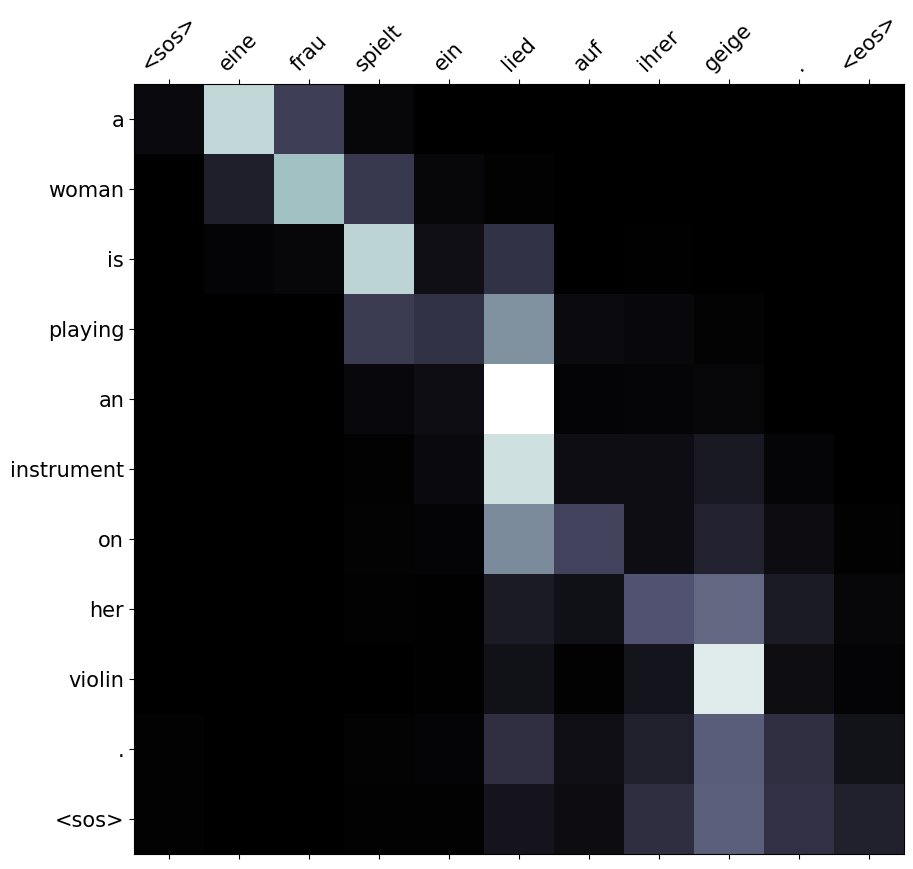

In [42]:
translation, attention = translate(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)